### Calculating the average token length of Datasets

In [2]:
from transformers import AutoTokenizer
from datasets import load_dataset

# Configuration
dataset_name = 'all_train'
root_path = 'full_dataset.json'

# Load dataset
data = load_dataset('json', data_files=root_path)
dialogs = data['train']

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3.1-8B-Instruct")

# Define data processing function
def process_dialog(batch):
    dialog_prompts = []
    dialog_completions = []
    for dialog in batch['messages']:  # Access the 'messages' field
        dialog_prompt = " ".join([msg['content'] for msg in dialog if msg['role'] == 'user'])
        dialog_completion = " ".join([msg['content'] for msg in dialog if msg['role'] == 'assistant'])
        dialog_prompts.append(dialog_prompt)
        dialog_completions.append(dialog_completion)
    return {"prompt": dialog_prompts, "completion": dialog_completions}

# Process dialogs using datasets.map
processed_data = dialogs.map(
    process_dialog,
    batched=True,
    batch_size=8,  # Adjust the batch size based on memory capacity
    num_proc=4
)

# Extract prompts and completions
prompts = processed_data['prompt']
completions = processed_data['completion']

# Batch tokenize data
prompts_tokenized = tokenizer(prompts, padding=False, truncation=False, return_length=True)
completions_tokenized = tokenizer(completions, padding=False, truncation=False, return_length=True)

# Compute average lengths
prompts_avg_tokens = sum(prompts_tokenized['length']) / len(prompts_tokenized['length'])
completions_avg_tokens = sum(completions_tokenized['length']) / len(completions_tokenized['length'])

# Print results
print(f"Prompts Average Tokens: {prompts_avg_tokens}")
print(f"Completions Average Tokens: {completions_avg_tokens}")


/home/jlpang/LLM_data_selection/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prompts Average Tokens: 156.13970930309839
Completions Average Tokens: 172.06477210798454


In [4]:

overall_lens = [prompt_len + completion_len for prompt_len, completion_len in zip(prompts_tokenized['length'], completions_tokenized['length'])]



sorted_indices = sorted(range(len(overall_lens)), key=lambda x: overall_lens[x])

# 根据排序后的索引提取值
sorted_lens = [overall_lens[i] for i in sorted_indices]

print("Sorted Indices:", sorted_indices[:10])  # 输出: [1, 0, 3, 2]
print("Sorted Lengths:", sorted_lens[:10])    # 输出: [5, 10, 15, 20]
import torch

torch.save(sorted_indices, "overall_len_indices_sorted.pt")
torch.save(sorted_lens, "overall_len_sorted.pt")

examples = data['train'].select(sorted_indices[:10])


Sorted Indices: [246267, 102351, 107094, 107955, 100248, 107093, 107103, 115978, 116457, 117625]
Sorted Lengths: [5, 6, 6, 6, 7, 7, 7, 7, 7, 7]


In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from datasets import load_dataset, Dataset
import random
import numpy as np
from tqdm import tqdm
import os

# Set random seed for reproducibility
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to calculate cosine distance and return KNN indices (excluding the sample itself)
def cosDistance(sample_embedding, all_embeddings, k_near=10):
    sample_embedding = sample_embedding.to(device)
    all_embeddings = all_embeddings.to(device)

    # Compute cosine similarity and convert to cosine distance
    similarity_vector = torch.matmul(all_embeddings, sample_embedding)
    distance_vector = 1.0 - similarity_vector

    # Get top-k nearest samples, including self at index 0
    distance_vector, topk_indices = torch.topk(distance_vector, k=k_near+1, dim=0, largest=False)

    # Exclude the sample itself from KNN results
    if topk_indices[0] == torch.arange(all_embeddings.size(0))[0]:
        topk_indices = topk_indices[1:]
        distance_vector = distance_vector[1:]

    return distance_vector, topk_indices

# Mean pooling function to obtain sentence embeddings
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Process dialog messages to convert into a text format
def process_dialog(dialog):
    conversation = ""
    for message in dialog['messages']:
        conversation += f"### {message['role']}: {message['content']}\n"
    return {"features": conversation}

# Generate embeddings for text
def embed_text(batch):
    encoded_inputs = tokenizer(batch['features'], padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        model_outputs = model(**encoded_inputs)
    sentence_embeddings = mean_pooling(model_outputs, encoded_inputs['attention_mask'])
    embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    
    batch['embeddings'] = embeddings.cpu().numpy().tolist()
    return batch

##############################################################################################################################

dataset_name = "all_train"

# Load or generate embeddings if they don't already exist
if not os.path.exists(f"{dataset_name}_embeddings.parquet"):
    
    print("calculating the embedding...")
    
    data = load_dataset('json', data_files=f"full_dataset.json")
    data['train'] = data['train'].map(process_dialog, batched=False)

    embedding_model_name = "BAAI/bge-large-en-v1.5"
    tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
    model = AutoModel.from_pretrained(embedding_model_name).to(device)
    model = torch.nn.DataParallel(model)

    data['train'] = data['train'].map(embed_text, batched=True, batch_size=2048)
    data['train'].to_parquet(f'{dataset_name}_embeddings.parquet')
    print(f"Embeddings saved to {dataset_name}_embeddings.parquet")

#########################################################################################################################


# Load generated embeddings dataset
embedding_dataset = load_dataset('parquet', data_files=f'{dataset_name}_embeddings.parquet')['train']

# Get all embeddings data
all_embeddings = torch.tensor(embedding_dataset['embeddings']).to(device)


knn_indices = []

# overall_len_sorted_indices = torch.load("overall_len_indices_sorted.pt")

# selected_short_example_indices = overall_len_sorted_indices ##check the len
# embedding_subset = embedding_dataset.select(selected_short_example_indices)

for sample_idx, sample in enumerate(tqdm(embedding_dataset, desc=f"Processing 2-NN samples")):
    sample_embedding = torch.tensor(sample['embeddings']).to(device)

    # Calculate cosine distance for the sample and retrieve KNN indices
    _, topk_indices = cosDistance(sample_embedding, all_embeddings, k_near=2)
    knn_indices.append(topk_indices.cpu().numpy().tolist())


# torch.save(knn_indices, "all_train_knn_indices.pt")

/home/jlpang/LLM_data_selection/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Generating train split: 300932 examples [00:18, 16704.52 examples/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4c2f31b280>>
Traceback (most recent call last):
  File "/home/jlpang/LLM_data_selection/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [6]:
dataset = load_dataset('json', data_files=f"full_dataset.json")['train']

dataset_name='all_train'
model_name="meta-llama/Meta-Llama-3.1-8B-Instruct"

In [37]:
len(knn_indices)

200

In [63]:
root_path = f"./model_finetune/selected_data/{model_name}/{dataset_name}/"
labels = torch.load(root_path + "output_labels_revised.pt", weights_only=True)

targe_example = 206
knn_examples = dataset.select(knn_indices[targe_example])

for knn_idx in [0,1,2]: ## 2-NN clusterability 0 means the original example 
    print("################")
    sample_idx = knn_indices[targe_example][knn_idx]
    print(f"Score: {labels[sample_idx]};; Example: {knn_examples[knn_idx]['messages']}")

################
Score: 3;; Example: [{'role': 'user', 'content': 'Title: curious about enlisting Review: a great read to see what kind of knowledge and techniques you should know before and after going to boot camp for the navy. It is also a great read for anyone who is interested in possibly joining. great price and fast shipping Is this product review negative?\nAnswer:'}, {'role': 'assistant', 'content': 'No'}]
################
Score: 3;; Example: [{'role': 'user', 'content': "Given the question: Title: A Great Buy, But A Bad Mistake Product review: After reading this book, I enlisted in the Navy. I wanted to become a Navy Seal. The problem is that I did not make the first day of BUD's. Warning: If you read this book, and like it, do not think about enlisting in the Navy. I made the mistake, so learn from me. This book is so detailed, you feel like you are part of the teams. Would you say this review depicts the product in a flattering or unflattering light?\nThe answer is:"}, {'ro

################
Score: 2;; Example: [{'role': 'user', 'content': 'Use the word "scrumptious" in a sentence.\n'}, {'role': 'assistant', 'content': 'The dinner was cooked to perfection and was absolutely scrumptious.'}]
################
Score: 2;; Example: [{'role': 'user', 'content': 'Delete two words from the following sentence to make it a valid sentence:\n\nI ate the most delicious dinner ever\n\n'}, {'role': 'assistant', 'content': 'I ate most delicious ever.'}]
################
Score: 2;; Example: [{'role': 'user', 'content': 'Task: Edit the following sentence to make it more concise: "The food that we ate for the party was absolutely delicious."\n\n'}, {'role': 'assistant', 'content': 'The food for the party was delicious.'}]



################
Score: 4;; Example: [{'role': 'user', 'content': 'List 3 applications of artificial intelligence'}, {'role': 'assistant', 'content': '\nSome applications of Artificial Intelligence include natural language processing, facial recognition, and self-driving cars.'}]
################
Score: 3;; Example: [{'role': 'user', 'content': 'Name 3 applications for artificial intelligence Output:'}, {'role': 'assistant', 'content': 'Three applications for artificial intelligence are natural language processing, computer vision, and facial recognition.'}]
################
Score: 1;; Example: [{'role': 'user', 'content': 'Name three artificial intelligence applications\n'}, {'role': 'assistant', 'content': 'Three artificial intelligence applications are: facial recognition software, natural language processing, and driverless cars.'}]


## check the score difference of 2-NN samples

/tmp/ipykernel_3380584/3403878622.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_train_knn_indices = torch.load("all_train_knn_indices.pt")
/tmp/ipykernel_3380584/

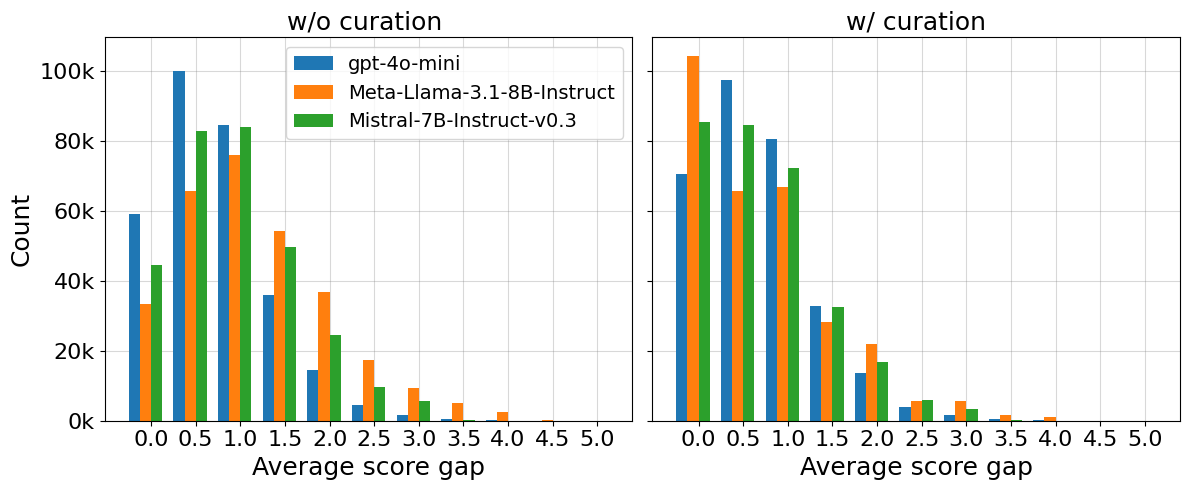

In [1]:
import torch
import os 
import math
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

def to_k_samples(y, _):
    return f"{y / 1000:.0f}k"

rating_models = ['gpt-4o-mini', "meta-llama/Meta-Llama-3.1-8B-Instruct", "mistralai/Mistral-7B-Instruct-v0.3"]
dataset_name = "all_train"


## knn_indices 
all_train_knn_indices = torch.load("all_train_knn_indices.pt")

# avg_knn_scores = {}
# knn_scores_statists = {}

# for is_curated in [True, False]:
    
#     for rating_model in rating_models:
#         ##load score
#         root_path = f"./model_finetune/selected_data/{rating_model}/{dataset_name}/"
#         if is_curated:
#             scores = torch.load(root_path + "output_labels_revised_cured.pt", weights_only=True)
#         else:            
#             scores = torch.load(root_path + "output_labels_revised.pt", weights_only=True)
        
#         avg_scores_per_model = []
#         for sample_knn_indices in all_train_knn_indices:
#             sample_scores = [scores[idx] for idx in sample_knn_indices]
#             avg_knn_score_gap = (abs(sample_scores[0]-sample_scores[1]) + abs(sample_scores[0]-sample_scores[2])) / 2
#             avg_scores_per_model.append(avg_knn_score_gap)

#         rating_model = os.path.basename(rating_model)    
#         avg_knn_scores[rating_model] = avg_scores_per_model
#         knn_scores_statists[rating_model] = Counter(avg_scores_per_model)
        

# # Plot histogram for each model
# plt.figure(figsize=(8, 5))
# bar_width = 0.25  # Width of each bar
# x_positions = {}  # To store positions for each model's bars

# # Generate x positions and bar heights
# keys_union = sorted(set().union(*[knn_scores_statists[os.path.basename(model)].keys() for model in rating_models]))
# x = np.arange(len(keys_union))  # Common x positions for all keys

# # Plot each model's data
# for i, rating_model in enumerate(rating_models):
#     model_name = os.path.basename(rating_model)
#     model_data = knn_scores_statists[model_name]
#     heights = [model_data.get(k, 0) for k in keys_union]
#     x_positions[model_name] = x + (i - len(rating_models) / 2) * bar_width
#     plt.bar(x_positions[model_name], heights, bar_width, label=model_name, zorder=2)

# # Add labels and legend
# plt.xlabel("Average Score Gap", fontsize=16)
# plt.ylabel("Count", fontsize=16)
# plt.title("Average Score Gaps across 2-NN Clusters", fontsize=16)
# plt.xticks(x, keys_union)
# plt.legend(fontsize=14)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(to_k_samples))
# plt.tick_params(axis='both', labelsize=14)
# plt.tight_layout()
# plt.grid(True, color='gray', alpha=0.3, zorder=0)

# # Display the plot
# plt.show()


# Prepare the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Loop through both is_curated cases
table_scores_all = {}
for idx, is_curated in enumerate([False, True]):
    avg_knn_scores = {}
    knn_scores_statists = {}
    table_scores_all[is_curated] = {}
    for rating_model in rating_models:
        # Load scores based on is_curated
        root_path = f"./model_finetune/selected_data/{rating_model}/{dataset_name}/"
        if is_curated:
            scores = torch.load(root_path + "output_labels_revised_cured.pt")
        else:
            scores = torch.load(root_path + "output_labels_revised.pt")

        avg_scores_per_model = []
        for sample_knn_indices in all_train_knn_indices:
            sample_scores = [scores[idx] for idx in sample_knn_indices]
            avg_knn_score_gap = (abs(sample_scores[0] - sample_scores[1]) + abs(sample_scores[0] - sample_scores[2])) / 2
            avg_scores_per_model.append(avg_knn_score_gap)

        rating_model = os.path.basename(rating_model)
        avg_knn_scores[rating_model] = avg_scores_per_model
        knn_scores_statists[rating_model] = Counter(avg_scores_per_model)
    table_scores_all[is_curated] = knn_scores_statists
        
    # Generate x positions and bar heights
    keys_union = sorted(set().union(*[knn_scores_statists[os.path.basename(model)].keys() for model in rating_models]))
    x = np.arange(len(keys_union))  # Common x positions for all keys

    # Plot each model's data in the respective subplot
    ax = axes[idx]
    bar_width = 0.25
    for i, rating_model in enumerate(rating_models):
        model_name = os.path.basename(rating_model)
        model_data = knn_scores_statists[model_name]
        heights = [model_data.get(k, 0) for k in keys_union]
        x_positions = x + (i - len(rating_models) / 2) * bar_width
        ax.bar(x_positions, heights, bar_width, label=model_name, zorder=2)

    # Add labels, title, and legend for the subplot
    ax.set_xlabel("Average score gap", fontsize=18)
    if idx == 0:
        ax.set_ylabel("Count", fontsize=18)
        ax.legend(fontsize=14)

    ax.set_title("w/ curation" if is_curated else "w/o curation ", fontsize=18)
    ax.set_xticks(x)
    ax.set_xticklabels(keys_union)
    ax.yaxis.set_major_formatter(FuncFormatter(to_k_samples))
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True, color='gray', alpha=0.3, zorder=0)

# Tight layout and show the plot
plt.tight_layout()
plt.show()


# knn_score_gap_statistis

In [7]:
import pandas as pd

# Prepare data for table with score_gap as columns
table_data = []

for is_curated, knn_scores_statists in table_scores_all.items():
    curated_label = "W/ Curation" if is_curated else "w/o Curation"
    for model_name, counter in knn_scores_statists.items():
        total_count = sum(counter.values())
        row = {
            "Curation": curated_label,
            "Model": model_name,
        }
        for gap, count in sorted(counter.items()):
            # row[f"Score Gap {gap}"] = count
            row[f"score gap {gap}(%)"] = round((count / total_count) * 100, 1)
        table_data.append(row)

# Convert to DataFrame
df = pd.DataFrame(table_data)

# Fill missing score gaps with 0 (if any)
df.fillna(0, inplace=True)

pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.max_columns', None)  # 显示所有列
pd.set_option('display.width', 1000)        # 增大输出宽度
pd.set_option('display.max_colwidth', None)  # 不限制单元格内容宽度

# Display the table
print(df)

# Optionally, save to a CSV or Excel file
df.to_csv("knn_score_gap_statistics_pivot.csv", index=False)


       Curation                       Model  score gap 0.0(%)  score gap 0.5(%)  score gap 1.0(%)  score gap 1.5(%)  score gap 2.0(%)  score gap 2.5(%)  score gap 3.0(%)  score gap 3.5(%)  score gap 4.0(%)  score gap 4.5(%)  score gap 5.0(%)
0  w/o Curation                 gpt-4o-mini              19.7              33.2              28.1              12.0               4.9               1.5               0.6               0.2               0.1               0.0               0.0
1  w/o Curation  Meta-Llama-3.1-8B-Instruct              11.1              21.9              25.3              18.0              12.2               5.8               3.1               1.7               0.9               0.1               0.0
2  w/o Curation    Mistral-7B-Instruct-v0.3              14.8              27.5              27.9              16.5               8.1               3.2               1.9               0.1               0.0               0.0               0.0
3   W/ Curation                 

| Curation        | Model                        | Score Gap 0.0 (%) | Score Gap 0.5(%) | Score Gap 1.0(%) | Score Gap 1.5(%) | Score Gap 2.0(%) | Score Gap 2.5(%) | Score Gap 3.0(%) | Score Gap 3.5(%) | Score Gap 4.0(%) | Score Gap 4.5(%) | Score Gap 5.0(%) |
|------------------|------------------------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|
| w/o Curation    | gpt-4o-mini                 | 19.66         | 33.19         | 28.06         | 11.97         | 4.86          | 1.47          | 0.55          | 0.17          | 0.06          | 0.01          | 0.00          |
| w/o Curation    | Meta-Llama-3.1-8B-Instruct  | 11.09         | 21.86         | 25.26         | 17.99         | 12.21         | 5.76          | 3.14          | 1.70          | 0.86          | 0.10          | 0.02          |
| w/o Curation    | Mistral-7B-Instruct-v0.3    | 14.83         | 27.48         | 27.94         | 16.49         | 8.10          | 3.20          | 1.89          | 0.07          | 0.01          | 0.00          | 0.00          |
| W/ Curation     | gpt-4o-mini                 | 23.44         | 32.31         | 26.76         | 10.91         | 4.50          | 1.34          | 0.52          | 0.15          | 0.05          | 0.01          | 0.00          |
| W/ Curation     | Meta-Llama-3.1-8B-Instruct  | 34.68         | 21.85         | 22.17         | 9.36          | 7.28          | 1.92          | 1.83          | 0.54          | 0.37          | 0.00          | 0.00          |
| W/ Curation     | Mistral-7B-Instruct-v0.3    | 28.36         | 28.11         | 24.03         | 10.80         | 5.59          | 1.93          | 1.13          | 0.03          | 0.01          | 0.00          | 0.00          |
